<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyzing-billions-of-passwords-from-Breach-compilation-dataset" data-toc-modified-id="Analyzing-billions-of-passwords-from-Breach-compilation-dataset-1">Analyzing billions of passwords from Breach compilation dataset</a></span><ul class="toc-item"><li><span><a href="#Data-Acquisition" data-toc-modified-id="Data-Acquisition-1.1">Data Acquisition</a></span></li><li><span><a href="#Data-Preparation/Cleaning" data-toc-modified-id="Data-Preparation/Cleaning-1.2">Data Preparation/Cleaning</a></span><ul class="toc-item"><li><span><a href="#Load-files-from-the-dir-recursively" data-toc-modified-id="Load-files-from-the-dir-recursively-1.2.1">Load files from the dir recursively</a></span></li><li><span><a href="#Dask-Dataframe-demo" data-toc-modified-id="Dask-Dataframe-demo-1.2.2">Dask Dataframe demo</a></span></li><li><span><a href="#Data-manipulation-via-Dask" data-toc-modified-id="Data-manipulation-via-Dask-1.2.3">Data manipulation via Dask</a></span></li></ul></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-1.3">Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Password-length-summary-dataset" data-toc-modified-id="Password-length-summary-dataset-1.3.1">Password length summary dataset</a></span></li><li><span><a href="#Domain-summary-statistics-dataset" data-toc-modified-id="Domain-summary-statistics-dataset-1.3.2">Domain summary statistics dataset</a></span></li></ul></li><li><span><a href="#Data-Enrichment" data-toc-modified-id="Data-Enrichment-1.4">Data Enrichment</a></span><ul class="toc-item"><li><span><a href="#Fortune-500-dataset-enrichment" data-toc-modified-id="Fortune-500-dataset-enrichment-1.4.1">Fortune 500 dataset enrichment</a></span></li><li><span><a href="#Merging-with-Domain-summary-dataset" data-toc-modified-id="Merging-with-Domain-summary-dataset-1.4.2">Merging with Domain summary dataset</a></span></li></ul></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-1.5">Data Visualization</a></span><ul class="toc-item"><li><span><a href="#Histogram-for-Password-Length" data-toc-modified-id="Histogram-for-Password-Length-1.5.1">Histogram for Password Length</a></span></li><li><span><a href="#Bar-chart-of-No-of-companies-per-Sector" data-toc-modified-id="Bar-chart-of-No-of-companies-per-Sector-1.5.2">Bar chart of No of companies per Sector</a></span></li><li><span><a href="#Password-Length-trends-in-Fortune-500-companies" data-toc-modified-id="Password-Length-trends-in-Fortune-500-companies-1.5.3">Password Length trends in Fortune 500 companies</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.6">Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-1.7">References</a></span></li></ul></li></ul></div>

# Analyzing billions of passwords from Breach compilation dataset

In this notebook, we will take a look at old database dump of 1.4 billion clear text credentials which was compilation of several data breaches including sites such as yahoo.com, LinkedIn etc. The complete database is an archive of 41 GB with around 1980 files. We will take a look at how this dataset can be loaded for scalable data analysis using python and perform common data cleaning and preparation steps. 

The goal of this presentation is to demonstrate how one can take real world large dataset, clean, enrich and perform data analysis at scale to extract interesting insights using Jupyter notebook.

## Data Acquisition

The links to original archive of 41 GB having 1981 files were found on various social media blogs 
with common [Pastebin](https://pastebin.com/R8Aj8Ncq) link containing both compressed 
and uncompressed version of the archive. The data is structured in an alphabetic directory 
tree fragmented in 1,981 pieces to allow fast searches. 
The dump includes search tools and insert scripts explained in a README file

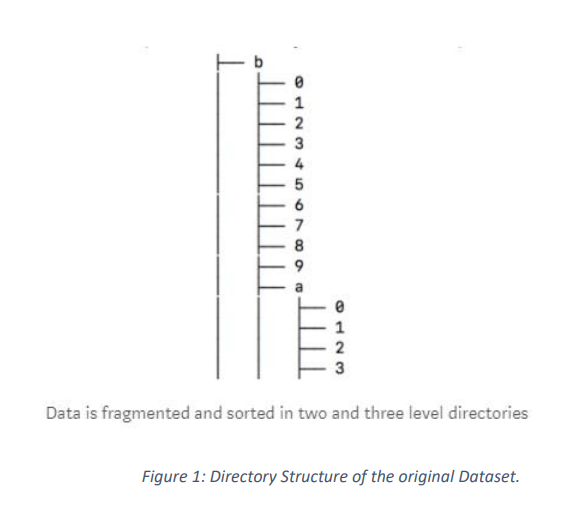

In [ ]:
!cat imported.log

## Data Preparation/Cleaning

- Files were with no extension. Use simple powershell to rename files and added .txt extension
```powershell
#To add extension to files
Get-ChildItem -Path "C:\BreachCompilation/" -File | Rename-Item -NewName { $PSItem.Name + ".txt" }
```

- Read each file and generate metata - No of lines and identify duplicates

    - Total files : 1986
    - Total Records: 140,055,3869 (1.4 Billion), 
    - Same Email Id and Password : 647701 - 0.04 %

***Out of Scope for Analysis***

    - No of duplicates : 202,281 (202K) - 0.014 %
    - Files with invalid data (all Null chars) :  105 Files - 1.93 GB - 4.8 %
    - Entries with Email but No Password : 2546790 - 0.18%
    - Entries with Password less than 6 chars : 40140152 - 2.86 % 

- Parse UserName:Password pair into 4 columns - EMail, Password, EmailID, EmailDomain.

- Output the final processed dataset for further analysis

***R Code References:***
- [Data Preprations-FileStats](https://github.com/ashwin-patil/springboard-intro-to-datascience/blob/master/capstone_project/00_Data_Preparation/DataPreparation-FileStats.R)
- [DataCleaning-Dups_NA_lessthan6](https://github.com/ashwin-patil/springboard-intro-to-datascience/blob/master/capstone_project/01_Data_Cleaning/DataCleaning-Dups_NA_lessthan6.R)

In [1]:
import glob
import dask.dataframe as dd
import pandas as pd
from urllib.parse import urlparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
sns.set(font_scale=1.4)

### Load files from the dir recursively

In [5]:
!pwd

/home/jovyan


In [6]:
files = glob.glob('/home/jovyan/work/Jupyterthon/BreachCompilation/Part01/*.txt', recursive = True)
files = files + glob.glob('/home/jovyan/work/Jupyterthon/BreachCompilation/Part01/*/*/*.txt', recursive = True)
files = files + glob.glob('/home/jovyan/work/Jupyterthon/BreachCompilation/Part01/*/*/*/*.txt', recursive = True)
files = files + glob.glob('/home/jovyan/work/Jupyterthon/BreachCompilation/Part01/*/*/*/*/*.txt', recursive = True)

len(files)

74

### Dask Dataframe demo

Typical Use cases
    - Manipulating large datasets, even when those datasets don’t fit in memory
    - Accelerating long computations by using many cores
    - Distributed computing on large datasets with standard pandas operations like groupby, join, and time series computations
    
**Docs::**
- [10 mins to Dask](https://docs.dask.org/en/stable/10-minutes-to-dask.html)
- [Best Practices](https://docs.dask.org/en/stable/best-practices.html)

In [7]:
all_files = dd.read_csv(files, on_bad_lines='skip', encoding='latin1', sep="\t", blocksize="25MB")
all_files

,EMail,Password,EMailID,EMailDomain
npartitions=146,,,,
,object,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [8]:
all_files.head()

,EMail,Password,EMailID,EMailDomain
0,AL00000@aol.com,bazookaz9,AL00000,aol.com
1,AL00001-06.12.1992@mail.ru,A00001,AL00001-06.12.1992,mail.ru
2,AL00001.92@mail.ru,Gonchik,AL00001.92,mail.ru
3,AL00013@yandex.ru,ibkjdf1330,AL00013,yandex.ru
4,AL0001NG@e.ntu.edu.sg,myanmarpyi,AL0001NG,e.ntu.edu.sg


### Data manipulation via Dask

In [9]:
# Filtering column by value
aol = all_files[all_files.EMailDomain == 'aol.com']

aol

,EMail,Password,EMailID,EMailDomain
npartitions=146,,,,
,object,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [10]:
aol_df = aol.compute()
aol_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1088899 entries, 0 to 108894
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   EMail        1088899 non-null  object
 1   Password     1087951 non-null  object
 2   EMailID      1088899 non-null  object
 3   EMailDomain  1088899 non-null  object
dtypes: object(4)
memory usage: 41.5+ MB


In [11]:
type(aol_df)

pandas.core.frame.DataFrame

In [12]:
aol_df.head()

,EMail,Password,EMailID,EMailDomain
0,AL00000@aol.com,bazookaz9,AL00000,aol.com
15,AL002WRIT@aol.com,cjohn1,AL002WRIT,aol.com
25,AL007LTK@aol.com,winkle12,AL007LTK,aol.com
26,AL008@aol.com,oreos8,AL008,aol.com
51,AL0201@aol.com,swimteam,AL0201,aol.com


In [13]:
# Group by count
# %%time

# unique_domain_stats = all_files.groupby('EMailDomain')['EMailID'].nunique().compute()

## Data Analysis

###  Password length summary dataset

In [15]:
pwd_length = pd.read_csv('/home/jovyan/work/Jupyterthon/Summary-PasswordLength.txt', sep="\t")

pwd_length

,PasswordLength,DistinctPasswords,DistinctEmailDomain,DistinctEmails,TotalCount
0,6,88573019,145292205,197625448,197625448
1,7,98472357,140926082,173206656,173206656
2,8,225238280,293375531,331599690,331599690
3,9,101889914,135110968,155991336,155991336
4,10,122724252,149603233,164837299,164837299
...,...,...,...,...,...
363,8199,1,1,1,1
364,15273,1,1,1,1
365,15288,2,2,2,2
366,15291,1,1,1,1


###  Domain summary statistics dataset

In [16]:
domain_summary_parquet = pd.read_parquet('/home/jovyan/work/Jupyterthon/summary_by_domain.parquet.gzip')
domain_summary_parquet.head()

,EMailDomain,PasswordLength,DistinctEmails,DistinctPasswords,TotalCount
0,-----------------------mail.ru,8,1,1,1
1,---------------------mail.ru,8,2,2,2
2,--------------------mail.ru,8,1,1,1
3,-------------------yahoo.com,8,1,1,1
4,--------------mail.ru,8,3,3,3


## Data Enrichment

### Fortune 500 dataset enrichment

In [18]:
def extract_domain_from_url(string):
    """ function to parse URL and extract domain"""
    parsed_url = urlparse(string).netloc
    domain = '.'.join(parsed_url.split('.')[-2:])
    return domain

fortune500 = pd.read_csv('/home/jovyan/work/Jupyterthon/Fortune_500_2017_from_data.world.csv')
fortune500['EMailDomain'] = fortune500['Website'].apply(extract_domain_from_url)

fortune500_domains = fortune500[['Title','Sector','EMailDomain']]
fortune500_domains.head()

,Title,Sector,EMailDomain
0,Walmart,Retailing,walmart.com
1,Berkshire Hathaway,Financials,berkshirehathaway.com
2,Apple,Technology,apple.com
3,Exxon Mobil,Energy,exxonmobil.com
4,McKesson,Wholesalers,mckesson.com


### Merging with Domain summary dataset

In [19]:
domain_by_sector = domain_summary_parquet.join(fortune500_domains.set_index('EMailDomain'), on='EMailDomain')
domain_by_sector = domain_by_sector.dropna().reset_index()

domain_by_sector.drop('index', axis=1, inplace=True)

domain_by_sector.head()

,EMailDomain,PasswordLength,DistinctEmails,DistinctPasswords,TotalCount,Title,Sector
0,aa.com,6,1545,1735,1916,American Airlines Group,Transportation
1,abbott.com,6,1985,1979,1999,Abbott Laboratories,Health Care
2,abbott.com,6,1985,1979,1999,St. Jude Medical,Health Care
3,abbvie.com,6,13,14,14,AbbVie,Health Care
4,abc.xyz,6,1,1,1,Alphabet,Technology


In [20]:
domain_by_sector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   EMailDomain        432 non-null    object
 1   PasswordLength     432 non-null    int64 
 2   DistinctEmails     432 non-null    int64 
 3   DistinctPasswords  432 non-null    int64 
 4   TotalCount         432 non-null    int64 
 5   Title              432 non-null    object
 6   Sector             432 non-null    object
dtypes: int64(4), object(3)
memory usage: 23.8+ KB


## Data Visualization

### Histogram for Password Length

In [21]:
# Filter dataset to better visualize with the right bins and length
pwdlength_under40 = pwd_length[pwd_length['PasswordLength'] < 40]

pwdlength_under40

,PasswordLength,DistinctPasswords,DistinctEmailDomain,DistinctEmails,TotalCount
0,6,88573019,145292205,197625448,197625448
1,7,98472357,140926082,173206656,173206656
2,8,225238280,293375531,331599690,331599690
3,9,101889914,135110968,155991336,155991336
4,10,122724252,149603233,164837299,164837299
5,11,30137025,39982292,42419776,42419776
6,12,21360053,28423887,30109078,30109078
7,13,11706077,15397072,16063998,16063998
8,14,8375177,11104867,11590256,11590256
9,15,12638936,14533050,14851668,14851668


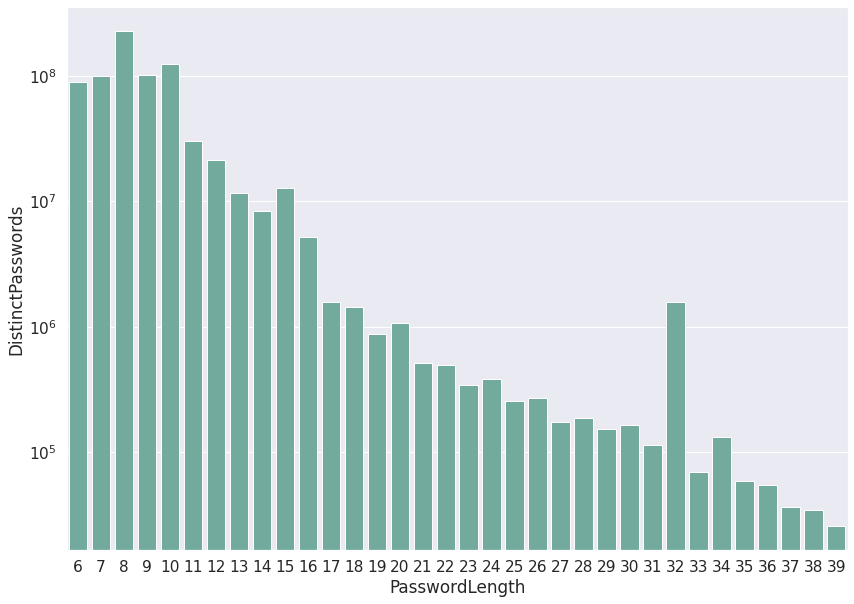

In [22]:
# Set the figure size
plt.figure(figsize=(14, 10))

plt.yscale('log')

# plot a bar chart
chart = sns.barplot(
    x="PasswordLength", 
    y="DistinctPasswords", 
    data=pwdlength_under40, 
    ci=None,
    color='#69b3a2');

### Bar chart of No of companies per Sector

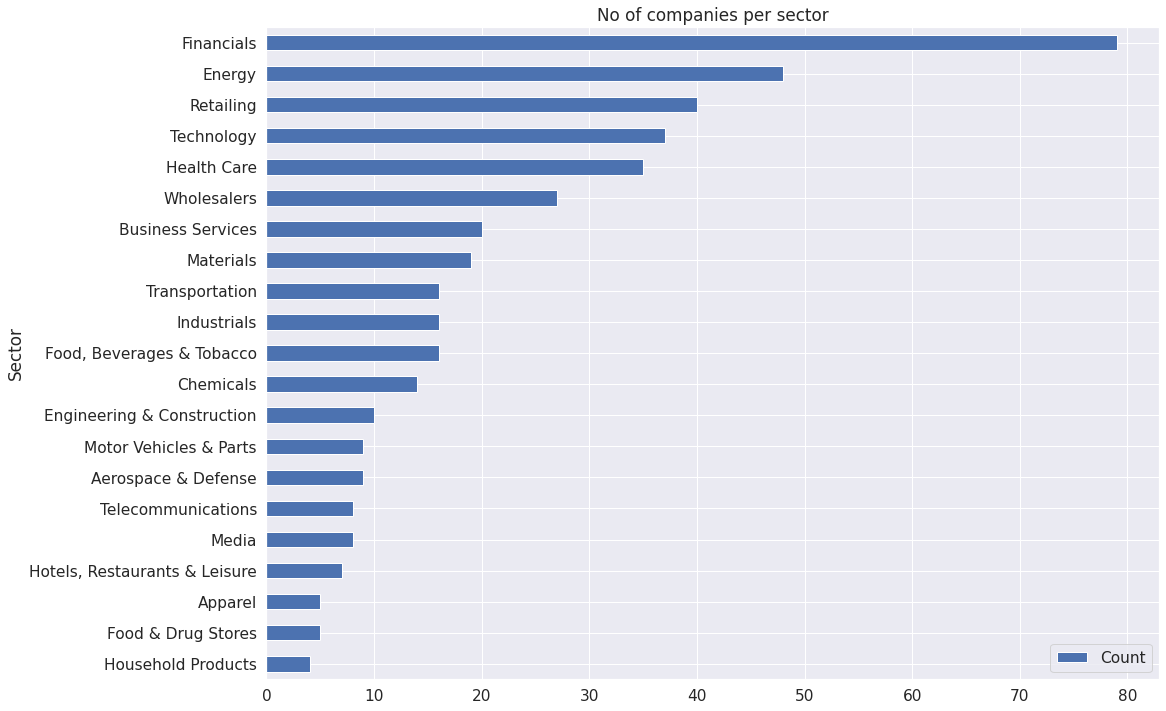

In [23]:
df_sector = domain_by_sector['Sector'].value_counts().to_frame(name='count').reset_index()
df_sector = df_sector.rename(index=str, columns={"index": "Sector", "count": "Count"}).sort_values(by='Count',ascending=True)

df_sector.plot.barh(x='Sector',y='Count',figsize=(16,12))
plt.title('No of companies per sector');

### Password Length trends in Fortune 500 companies

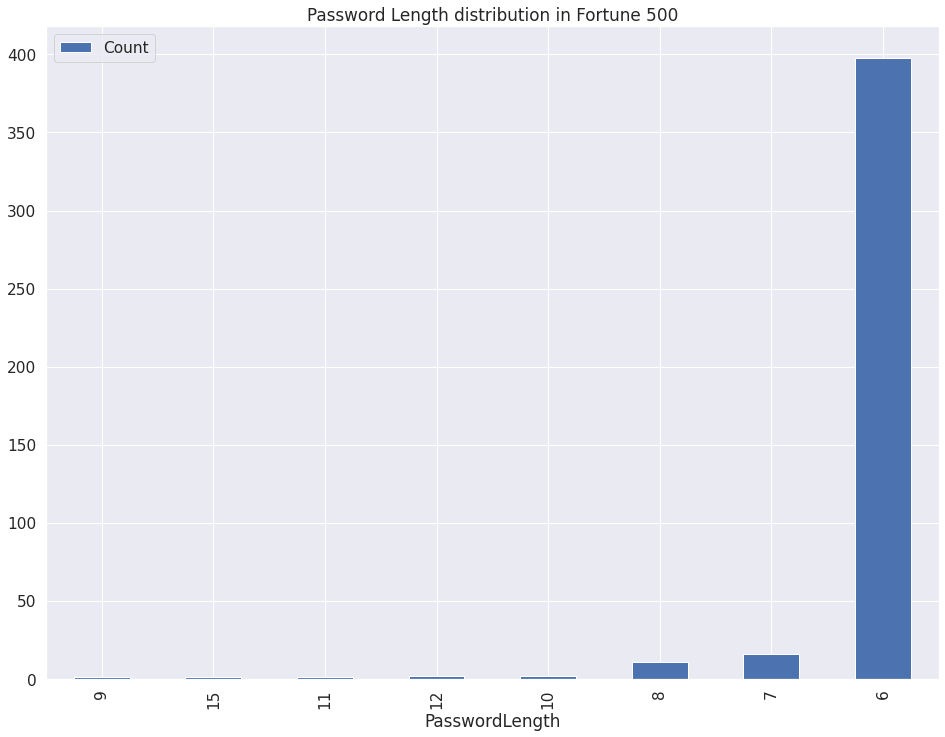

In [24]:
df_sector_pwdlength = domain_by_sector['PasswordLength'].value_counts().to_frame(name='count').reset_index()
df_sector_pwdlength = df_sector_pwdlength.rename(index=str, columns={"index": "PasswordLength", "count": "Count"}).sort_values(by='Count',ascending=True)

df_sector_pwdlength.plot.bar(x='PasswordLength',y='Count',figsize=(16,12))
plt.title('Password Length distribution in Fortune 500');

## Conclusion
In this presentation, we take a look at real world database dump and how to load it in Jupyter notebook and derive interesting insights. The dataset had lot of quality issues and requires many preparation and clean-up steps. The database also just had email domain and password but we are able to enrich that dataset to categorize password patterns per sectors. We were able to navigate the various challenges during this process and learned generic workflow than can be repeated on new datasets. Often analysts will have data already ingested in powerful analytical tools, but in some rare occurences when you encounter large set of data that need to be quickly analyzed , these methodologies can be useful. 


## References

- https://medium.com/4iqdelvedeep/1-4-billion-clear-text-credentials-discovered-in-a-single-database-3131d0a1ae14
- https://www.reddit.com/r/pwned/comments/7hhqfo/combination_of_many_breaches/
- https://data.world/aurielle/fortune-500-2017
- https://github.com/ashwin-patil/springboard-intro-to-datascience/tree/master/capstone_project
- https://github.com/ashwin-patil/springboard-intro-to-datascience/blob/master/capstone_project/Analysis%20of%20Passwords%20from%20BreachCompilation%20Dataset-ver2.pdf